## Overlay com Mapa


In [1]:
# pip install folium

In [2]:
# pip install geopandas

In [3]:
# Radar location and radius
SUMARE_RADAR_LAT = -22.955139
SUMARE_RADAR_LON = -43.248278
SUMARE_RADAR_RADIUS = 138900  # in meters

RADAR_IMAGE_FILE = "../../data/radar_sumare/2019/04/08/2019_04_08_12_52.png"

In [4]:
import pandas as pd
import folium
from math import cos, asin, sqrt

In [5]:
m = folium.Map([SUMARE_RADAR_LAT, SUMARE_RADAR_LON], zoom_start=8, tiles='cartodbpositron')

colormap = ['magenta', 'red', 'orange', 'yellow']
folium.LatLngPopup().add_to(m)

In [6]:
df_surface_stations = pd.read_csv('../../config/SurfaceStations.csv')

# Estações INMET
# df = pd.read_json('https://apitempo.inmet.gov.br/estacoes/T')
df_INMET_stations = df_surface_stations[(df_surface_stations['SYSTEM'] == 'INMET') & (df_surface_stations['SG_ESTADO'] == 'RJ')]
df_AlertaRio_stations = df_surface_stations[(df_surface_stations['SYSTEM'] == 'ALERTA_RIO') & (df_surface_stations['SG_ESTADO'] == 'RJ')]

# INMET stations
lat = list(df_INMET_stations.VL_LATITUDE)
lon = list(df_INMET_stations.VL_LONGITUDE)

# Plot INMET stations
for loc in zip(lat, lon):
    folium.Circle(
        location=loc,
        radius=20,
        fill=True,
        color='purple',
        fill_opacity=0.7
    ).add_to(m)

loc = (SUMARE_RADAR_LAT, SUMARE_RADAR_LON)
folium.Circle(
        location=loc,
        radius=100,
        fill=True,
        color='black',
        fill_opacity=0.7
).add_to(m)

# Plot radar coverage
folium.Circle(
        size=20,
        location=loc,
        radius=SUMARE_RADAR_RADIUS,
        fill=True,
        color='gray',
        fill_opacity=0.1
    ).add_to(m)
m

### 🌍 Why do we use the value **111.32**?

The value **111.32** represents the **average distance (in kilometers) corresponding to one degree of latitude on Earth**.

---

### 1️⃣ Explanation

The Earth is approximately an oblate spheroid, with an average radius  
$$ 
R \approx 6,371 \, \text{km} 
$$.  
The Earth's circumference is about:

$$
C = 2 \pi R \approx 40,075 \, \text{km}
$$

Since the full circle corresponds to 360°, each degree of **latitude** corresponds to:

$$
\frac{40,075}{360} \approx 111.32 \, \text{km per degree}
$$

That’s why we use:

```python
deg_lat = radius_km / 111.32
````

This converts a distance (in km) into degrees of latitude.

---

### 2️⃣ Longitude conversion

For **longitude**, the distance per degree **depends on the latitude**,
because meridians converge toward the poles. The relationship is:

$$
1°_\text{lon} = 111.32 \times \cos(\text{latitude})
$$

So to convert a radius (in km) into degrees of longitude:

```python
deg_lon = radius_km / (111.32 * math.cos(math.radians(latitude)))
```

---

### 3️⃣ Summary

| Quantity        | Approximation               | Interpretation                        |
| --------------- | --------------------------- | ------------------------------------- |
| 1° latitude     | ≈ 111.32 km                 | Almost constant everywhere            |
| 1° longitude    | ≈ 111.32 × cos(latitude) km | Decreases toward the poles            |
| Source of value | ( 40,075 / 360 )            | Earth’s circumference divided by 360° |

---

### 4️⃣ Optional — more precise formulas

If higher precision is needed (considering Earth’s flattening), we can use:

$$
1°*\text{lat} = 111.13295 - 0.55982 \cos(2\phi) + 0.00117 \cos(4\phi)
$$
$$
1°*\text{lon} = 111.41288 \cos(\phi) - 0.09350 \cos(3\phi) + 0.00012 \cos(5\phi)
$$

But for practical cases (such as overlaying a 140 km radar image) the simple **111.32 km per degree** approximation is more than accurate enough.

In [7]:
import math
 
# Convert radius from meters to degrees
radius_km = SUMARE_RADAR_RADIUS / 1000
deg_lat = radius_km / 111.32
deg_lon = radius_km / (111.32 * math.cos(math.radians(SUMARE_RADAR_LAT)))

lat_min = SUMARE_RADAR_LAT - deg_lat
lat_max = SUMARE_RADAR_LAT + deg_lat
lon_min = SUMARE_RADAR_LON - deg_lon
lon_max = SUMARE_RADAR_LON + deg_lon
 
bounds = [[lat_min, lon_min], [lat_max, lon_max]]

bounds

[[-24.20289322206252, -44.60333880587445],
 [-21.707384777937477, -41.89321719412555]]


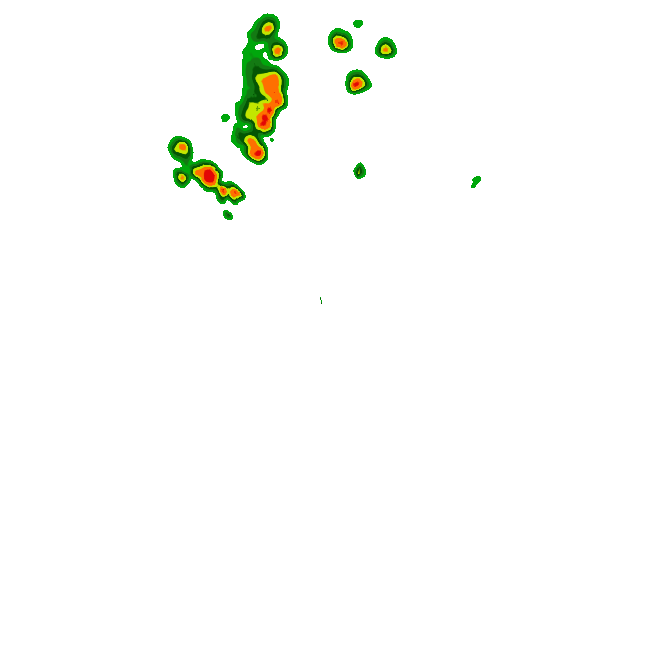

In [8]:
folium.raster_layers.ImageOverlay(
    image=RADAR_IMAGE_FILE,
    bounds=bounds,
    colormap=lambda x: (1, 0, 0, x),
    origin="lower",
    opacity=0.5,
).add_to(m)

m

## Overlay na imagem

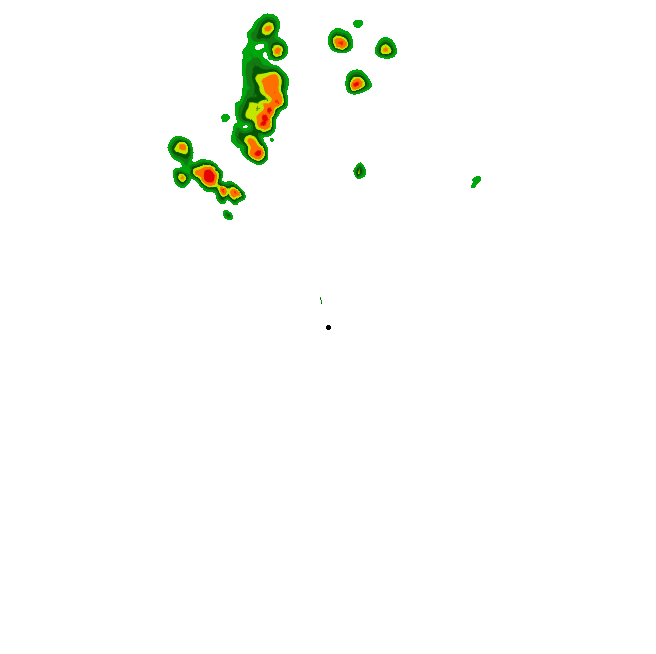

In [9]:
from PIL import Image, ImageDraw
import pandas as pd

# See https://g1.globo.com/rj/rio-de-janeiro/noticia/2019/04/09/bombeiros-registram-deslizamento-no-morro-da-babilonia-rio.ghtml
RADAR_FRAME_FOR_TESTING = Image.open("../../data/radar_sumare/2019/04/08/2019_04_08_12_52.png")

draw = ImageDraw.Draw(RADAR_FRAME_FOR_TESTING)
draw.circle((RADAR_FRAME_FOR_TESTING.width/2,RADAR_FRAME_FOR_TESTING.height/2),2,"black")
RADAR_FRAME_FOR_TESTING

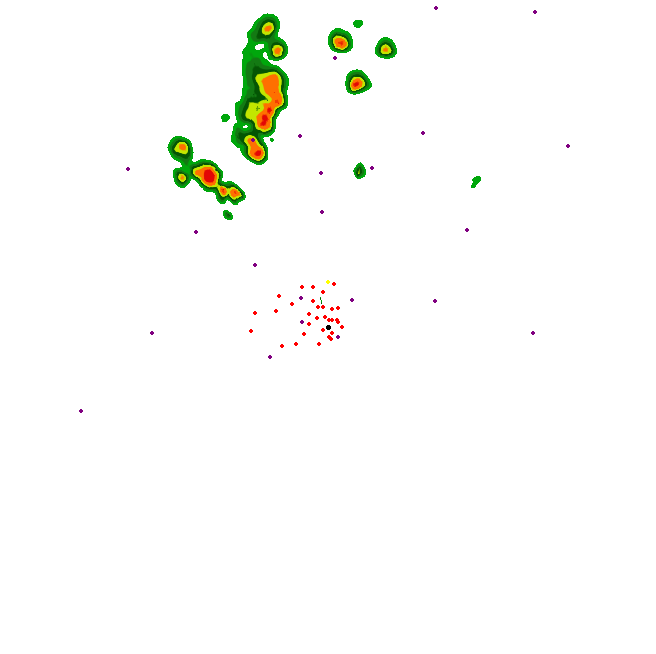

In [10]:
# pos_sumare = (-22.955139,-43.248278)
pos_sumare_img = (RADAR_FRAME_FOR_TESTING.height/2, RADAR_FRAME_FOR_TESTING.width/2)

dify = (pos_sumare_img[0]/SUMARE_RADAR_LAT)
difx = (pos_sumare_img[1]/SUMARE_RADAR_LON)

# Desenha as estações do AlertaRio em vermelho
lat = list(df_AlertaRio_stations.VL_LATITUDE)
lon = list(df_AlertaRio_stations.VL_LONGITUDE)

for loc in zip(lat, lon):
    posx = SUMARE_RADAR_LON - ((loc[1] - SUMARE_RADAR_LON) * 22)
    valorx = posx * difx

    posy = SUMARE_RADAR_LAT + ((loc[0] - SUMARE_RADAR_LAT) * 22)
    valory = posy * dify
    draw.circle((valorx,valory),1.5,"red")


# Desenha as estações do INMET em roxo
lat = list(df_INMET_stations.VL_LATITUDE)
lon = list(df_INMET_stations.VL_LONGITUDE)

for loc in zip(lat, lon):
    posx = SUMARE_RADAR_LON - ((loc[1] - SUMARE_RADAR_LON) * 22)
    valorx = posx * difx

    posy = SUMARE_RADAR_LAT + ((loc[0] - SUMARE_RADAR_LAT) * 22)
    valory = posy * dify
    draw.circle((valorx,valory),1.5,"purple")

lat = [-22.81]
lon = [-43.25]

for loc in zip(lat, lon):
    posx = SUMARE_RADAR_LON - ((loc[1] - SUMARE_RADAR_LON) * 22)
    valorx = posx * difx

    posy = SUMARE_RADAR_LAT + ((loc[0] - SUMARE_RADAR_LAT) * 22)
    valory = posy * dify
    draw.circle((valorx,valory),1.5,"yellow")

RADAR_FRAME_FOR_TESTING

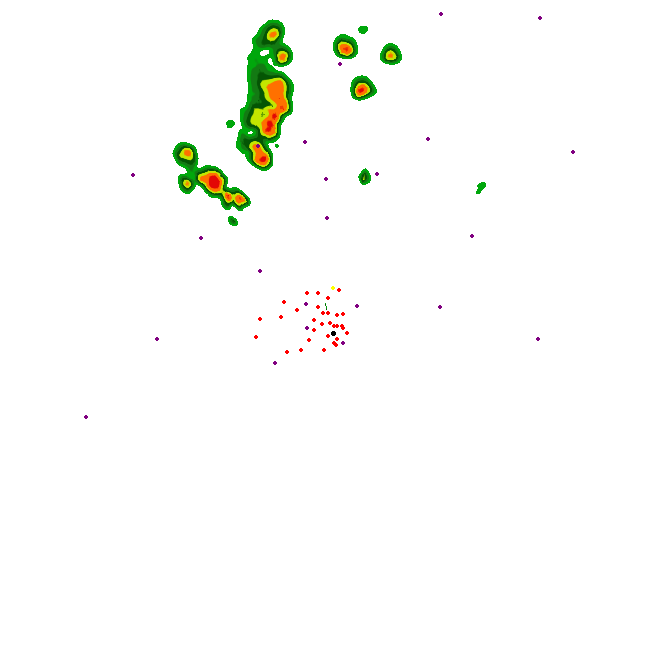

In [11]:
width, height = RADAR_FRAME_FOR_TESTING.size   # Get dimensions
new_width = new_height =666
left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

# Crop the center of the image
tst2 = RADAR_FRAME_FOR_TESTING.crop((left, top, right, bottom))
tst2

In [12]:
### 🌧️ Georeferencing the Sumaré radar PNG image
#     (automatic pixel size from image dimensions and physical radius)

import numpy as np
from pyproj import Transformer
import folium

# --- Radar parameters
SUMARE_RADAR_LAT = -22.955139
SUMARE_RADAR_LON = -43.248278
SUMARE_RADAR_RADIUS = 138_900     # meters (physical radar coverage)
IMG_WIDTH  = 656
IMG_HEIGHT = 654

# --- 1. Compute pixel spacing from known physical radius
PIXEL_SIZE_X = (2 * SUMARE_RADAR_RADIUS) / IMG_WIDTH   # ≈ 424.5 m
PIXEL_SIZE_Y = (2 * SUMARE_RADAR_RADIUS) / IMG_HEIGHT  # ≈ 425.0 m
print(f"Pixel spacing (X, Y): {PIXEL_SIZE_X:.2f} m × {PIXEL_SIZE_Y:.2f} m")

# --- 2. Define coordinate transforms
to_utm = Transformer.from_crs("EPSG:4326", "EPSG:31983", always_xy=True)
to_geo = Transformer.from_crs("EPSG:31983", "EPSG:4326", always_xy=True)

# --- 3. Convert radar center to UTM
x0, y0 = to_utm.transform(SUMARE_RADAR_LON, SUMARE_RADAR_LAT)

# --- 4. Define UTM bounds
R = SUMARE_RADAR_RADIUS
x_min, x_max = x0 - R, x0 + R
y_min, y_max = y0 - R, y0 + R

# --- 5. Build UTM grid matching image dimensions
x = np.linspace(x_min, x_max, IMG_WIDTH)
y = np.linspace(y_min, y_max, IMG_HEIGHT)
xx, yy = np.meshgrid(x, y)

# --- 6. Convert grid back to geographic coordinates
lon, lat = to_geo.transform(xx, yy)

# These arrays now map each pixel center to a geographic coordinate
print("Latitude grid shape:", lat.shape, "Longitude grid shape:", lon.shape)


Pixel spacing (X, Y): 423.48 m × 424.77 m
Latitude grid shape: (654, 656) Longitude grid shape: (654, 656)


# Overlay on a Folium map


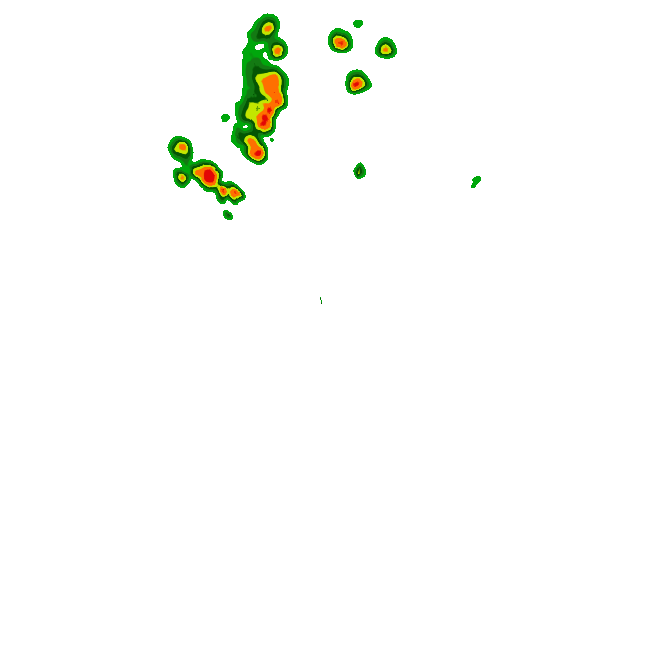

In [13]:
import folium

# --- Criação do mapa centrado no radar ---
m = folium.Map(location=[SUMARE_RADAR_LAT, SUMARE_RADAR_LON], zoom_start=8)

# --- Overlay da imagem do radar ---
folium.raster_layers.ImageOverlay(
    image=RADAR_IMAGE_FILE,
    bounds=bounds,        # calculado anteriormente
    opacity=0.6
).add_to(m)

# --- Marcador do centro do radar ---
folium.CircleMarker(
    location=[SUMARE_RADAR_LAT, SUMARE_RADAR_LON],
    radius=4,
    color="red",
    fill=True,
    fill_opacity=1,
    popup="Radar Sumaré (centro)"
).add_to(m)

# --- Função auxiliar para deslocar o rótulo levemente para norte (em graus) ---
def offset_lat(lat, offset_m):
    """Aproxima deslocamento norte em metros → graus latitude"""
    return lat + (offset_m / 111_320.0)

# --- Círculos concêntricos + rótulos ---
range_km = [50, 100, 138.9]
colors = ["#8888ff", "#4444ff", "#000000"]

for r_km, color in zip(range_km, colors):
    radius_m = r_km * 1000

    # Círculo de alcance
    folium.Circle(
        location=[SUMARE_RADAR_LAT, SUMARE_RADAR_LON],
        radius=radius_m,
        color=color,
        weight=1.2,
        fill=True,
        fill_opacity=0.08 if r_km < 138.9 else 0,
        popup=f"Alcance: {r_km:.1f} km"
    ).add_to(m)

    # Rótulo de texto sobre o mapa (ligeiramente acima do centro)
    folium.map.Marker(
        [offset_lat(SUMARE_RADAR_LAT, radius_m + 3000), SUMARE_RADAR_LON],
        icon=folium.DivIcon(
            html=f"""
            <div style="
                font-size: 11pt;
                color: {color};
                text-align: center;
                font-weight: bold;
                background-color: rgba(255,255,255,0.7);
                border-radius: 5px;
                padding: 2px 6px;
            ">{r_km:.0f} km</div>
            """
        )
    ).add_to(m)

m


In [14]:
import pandas as pd

# Lê o arquivo CSV de estações
stations = pd.read_csv("../../config/SurfaceStations.csv")

# Mostra as primeiras linhas
stations.head()


,SYSTEM,STATION_ID,DC_NOME,SG_ESTADO,CD_SITUACAO,VL_LATITUDE,VL_LONGITUDE,VL_ALTITUDE,DT_INICIO_OPERACAO
0,INMET,A628,ANGRA DOS REIS,RJ,Operante,-22.975556,-44.303333,6.0,2017-08-24
1,INMET,A606,ARRAIAL DO CABO,RJ,Operante,-22.975278,-42.021389,5.0,2006-09-21
2,INMET,A604,CAMBUCI,RJ,Operante,-21.587500,-41.958333,46.0,2002-11-19
3,INMET,A607,CAMPOS DOS GOYTACAZES,RJ,Operante,-21.714722,-41.343889,17.0,2006-09-24
4,INMET,A620,CAMPOS DOS GOYTACAZES - SAO TOME,RJ,Operante,-22.041667,-41.051667,7.0,2008-06-12



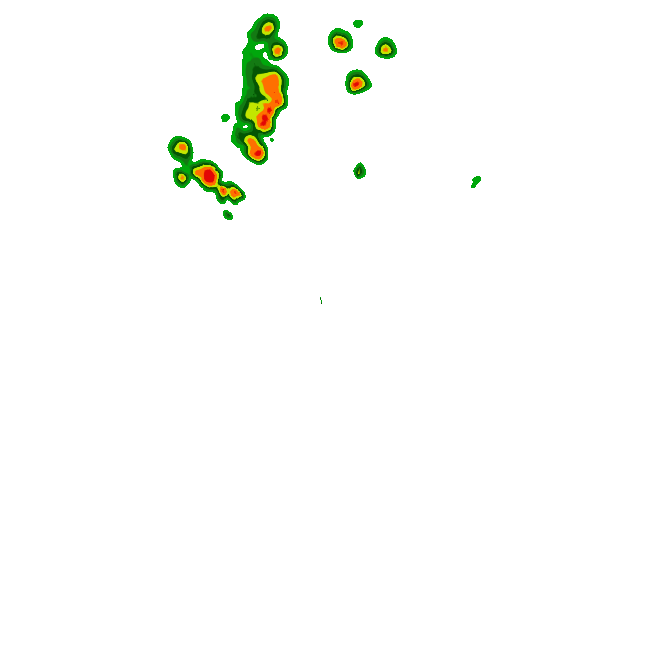

In [15]:
# Adiciona as estações como marcadores no mapa Folium
for _, row in stations.iterrows():
    lat = row["VL_LATITUDE"]
    lon = row["VL_LONGITUDE"]
    name = row.get("DC_NOME", "Estação")
    system = row.get("SYSTEM", "")
    
    folium.CircleMarker(
        location=[lat, lon],
        radius=3.5,
        color="blue" if system == "INMET" else "green",
        fill=True,
        fill_opacity=0.8,
        popup=f"<b>{name}</b><br>Sistema: {system}<br>({lat:.4f}, {lon:.4f})"
    ).add_to(m)

m


53 estações dentro do alcance do radar.



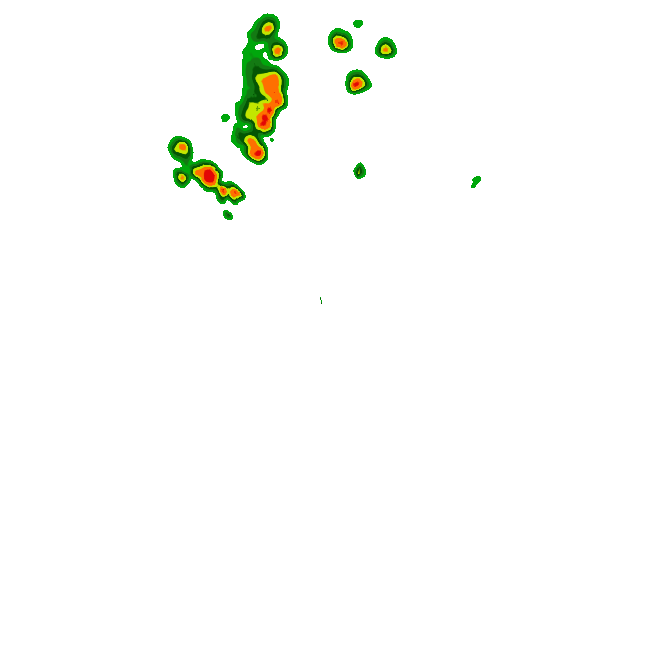

In [18]:
import folium
import pandas as pd
from math import radians, sin, cos, sqrt, atan2

# --- Leitura do CSV de estações ---
stations = pd.read_csv("../../config/SurfaceStations.csv")

# --- Função para calcular distância haversine (em metros) ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3  # raio médio da Terra
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# --- Cálculo da distância de cada estação até o radar ---
stations["DIST_RADAR_M"] = stations.apply(
    lambda r: haversine(SUMARE_RADAR_LAT, SUMARE_RADAR_LON, r.VL_LATITUDE, r.VL_LONGITUDE),
    axis=1
)

# --- Filtra apenas estações dentro do alcance do radar ---
stations_in_range = stations[stations["DIST_RADAR_M"] <= SUMARE_RADAR_RADIUS]
print(f"{len(stations_in_range)} estações dentro do alcance do radar.")

# --- Criação do mapa ---
m = folium.Map(location=[SUMARE_RADAR_LAT, SUMARE_RADAR_LON], zoom_start=8)

# --- Overlay da imagem de radar ---
folium.raster_layers.ImageOverlay(
    image=RADAR_IMAGE_FILE,
    bounds=bounds,
    opacity=0.6
).add_to(m)

# --- Marcador do centro do radar ---
folium.CircleMarker(
    location=[SUMARE_RADAR_LAT, SUMARE_RADAR_LON],
    radius=4,
    color="red",
    fill=True,
    fill_opacity=1,
    popup="Radar Sumaré (centro)"
).add_to(m)

# --- Função auxiliar para deslocar rótulo (norte) ---
def offset_lat(lat, offset_m):
    return lat + (offset_m / 111_320.0)

# --- Círculos concêntricos + rótulos ---
range_km = [50, 100, 138.9]
colors = ["#8888ff", "#4444ff", "#000000"]

for r_km, color in zip(range_km, colors):
    radius_m = r_km * 1000
    folium.Circle(
        location=[SUMARE_RADAR_LAT, SUMARE_RADAR_LON],
        radius=radius_m,
        color=color,
        weight=1.2,
        fill=True,
        fill_opacity=0.08 if r_km < 138.9 else 0,
        popup=f"Alcance: {r_km:.1f} km"
    ).add_to(m)

    # Rótulo de texto no anel
    folium.map.Marker(
        [offset_lat(SUMARE_RADAR_LAT, radius_m + 3000), SUMARE_RADAR_LON],
        icon=folium.DivIcon(
            html=f"""
            <div style="
                font-size: 10pt;
                color: {color};
                text-align: center;
                font-weight: bold;
                background-color: rgba(255,255,255,0.7);
                border-radius: 5px;
                padding: 2px 6px;
            ">{r_km:.0f} km</div>
            """
        )
    ).add_to(m)

# --- Plot das estações (cores e ícones por sistema) ---
for _, row in stations_in_range.iterrows():
    lat, lon = row["VL_LATITUDE"], row["VL_LONGITUDE"]
    name = row.get("DC_NOME", "Estação")
    system = row.get("SYSTEM", "")

    if system.upper() == "INMET":
        icon = folium.Icon(color="blue", icon="triangle", prefix="fa")
    else:
        icon = folium.Icon(color="green", icon="circle", prefix="fa")

    folium.Marker(
        location=[lat, lon],
        icon=icon,
        popup=f"<b>{name}</b><br>Sistema: {system}<br>({lat:.4f}, {lon:.4f})"
    ).add_to(m)

m



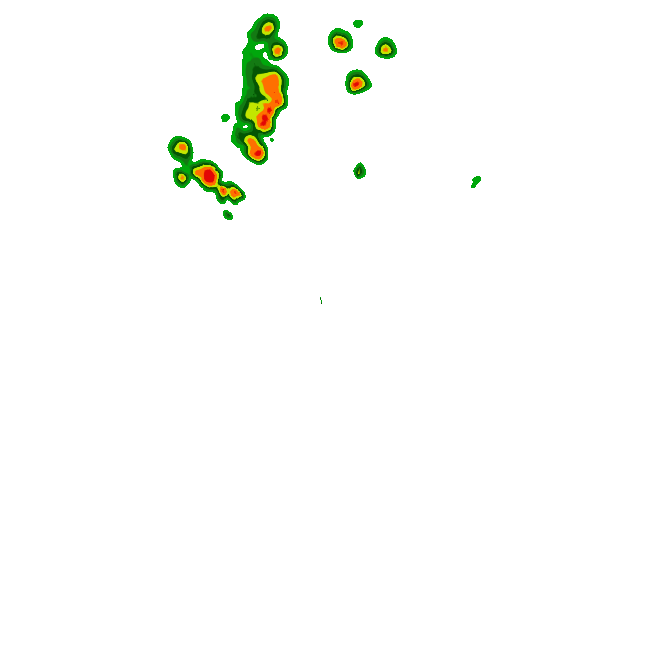

In [19]:
import folium
import pandas as pd
from math import radians, sin, cos, sqrt, atan2

# --- Leitura do CSV de estações ---
stations = pd.read_csv("../../config/SurfaceStations.csv")

# --- Função haversine para distância até o radar ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3  # raio médio da Terra (m)
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

stations["DIST_RADAR_M"] = stations.apply(
    lambda r: haversine(SUMARE_RADAR_LAT, SUMARE_RADAR_LON, r.VL_LATITUDE, r.VL_LONGITUDE),
    axis=1
)

# --- Filtra apenas estações dentro do alcance do radar ---
stations_in_range = stations[stations["DIST_RADAR_M"] <= SUMARE_RADAR_RADIUS]

# --- Cria o mapa base ---
m = folium.Map(location=[SUMARE_RADAR_LAT, SUMARE_RADAR_LON], zoom_start=8)

# --- Overlay da imagem do radar ---
folium.raster_layers.ImageOverlay(
    image=RADAR_IMAGE_FILE,
    bounds=bounds,
    opacity=0.6
).add_to(m)

# --- Marcador do radar ---
folium.CircleMarker(
    location=[SUMARE_RADAR_LAT, SUMARE_RADAR_LON],
    radius=4,
    color="red",
    fill=True,
    fill_opacity=1,
    popup="Radar Sumaré (centro)"
).add_to(m)

# --- Função auxiliar para deslocar rótulo ---
def offset_lat(lat, offset_m):
    return lat + (offset_m / 111_320.0)

# --- Círculos concêntricos + rótulos ---
range_km = [50, 100, 138.9]
colors = ["#8888ff", "#4444ff", "#000000"]

for r_km, color in zip(range_km, colors):
    radius_m = r_km * 1000
    folium.Circle(
        location=[SUMARE_RADAR_LAT, SUMARE_RADAR_LON],
        radius=radius_m,
        color=color,
        weight=1.2,
        fill=True,
        fill_opacity=0.08 if r_km < 138.9 else 0,
        popup=f"Alcance: {r_km:.1f} km"
    ).add_to(m)

    folium.map.Marker(
        [offset_lat(SUMARE_RADAR_LAT, radius_m + 3000), SUMARE_RADAR_LON],
        icon=folium.DivIcon(
            html=f"""
            <div style="
                font-size: 10pt;
                color: {color};
                text-align: center;
                font-weight: bold;
                background-color: rgba(255,255,255,0.7);
                border-radius: 5px;
                padding: 2px 6px;
            ">{r_km:.0f} km</div>
            """
        )
    ).add_to(m)

# --- Cria grupos de camadas ---
layer_inmet = folium.FeatureGroup(name="Estações INMET", show=True)
layer_alerta = folium.FeatureGroup(name="Estações AlertaRio", show=True)

# --- Adiciona estações de cada sistema ---
for _, row in stations_in_range.iterrows():
    lat, lon = row["VL_LATITUDE"], row["VL_LONGITUDE"]
    name = row.get("DC_NOME", "Estação")
    system = row.get("SYSTEM", "")

    if system.upper() == "INMET":
        folium.CircleMarker(
            location=[lat, lon],
            radius=2.5,  # marcador menor
            color="blue",
            fill=True,
            fill_opacity=0.9,
            popup=f"<b>{name}</b><br>Sistema: {system}<br>({lat:.4f}, {lon:.4f})"
        ).add_to(layer_inmet)
    else:
        folium.CircleMarker(
            location=[lat, lon],
            radius=2.5,
            color="green",
            fill=True,
            fill_opacity=0.9,
            popup=f"<b>{name}</b><br>Sistema: {system}<br>({lat:.4f}, {lon:.4f})"
        ).add_to(layer_alerta)

# --- Adiciona as camadas ao mapa ---
layer_inmet.add_to(m)
layer_alerta.add_to(m)

# --- Controle de visibilidade das camadas ---
folium.LayerControl(collapsed=False).add_to(m)

# --- Adiciona legenda fixa ---
legend_html = """
<div style="
    position: fixed;
    bottom: 30px;
    right: 30px;
    width: 180px;
    background-color: rgba(255, 255, 255, 0.9);
    border: 2px solid gray;
    border-radius: 8px;
    padding: 8px;
    font-size: 12px;
    z-index:9999;
">
<b>🛰️ Legenda</b><br>
<span style="color:red;">●</span> Radar Sumaré<br>
<span style="color:blue;">●</span> Estações INMET<br>
<span style="color:green;">●</span> Estações AlertaRio<br>
<span style="color:#000000;">⬤</span> Círculo de alcance<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

m
